<a href="https://colab.research.google.com/github/PaulVanDev/HoeffdingD/blob/master/EfficientHoeffdingD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
from scipy.stats import rankdata
from scipy.signal import decimate
import math
import time
import matplotlib.pyplot as plt
from sklearn.preprocessing import KBinsDiscretizer

# Direct transcription of Matlab code / Used as reference

References:
matlab code

https://stackoverflow.com/questions/9270496/ideas-for-gpu-implementation-of-hoeffdings-d-dependence-coefficient/9322657#9322657

HoeffdingD formule

http://support.sas.com/documentation/cdl/en/procstat/63104/HTML/default/viewer.htm#procstat_corr_sect016.htm

In [0]:
# Direct transcription of R code / Used as reference
def hoeffdingsD( x, y ):

    #N = size(x,1);
    N=x.shape
    #R = tiedrank( x );
    R=rankdata(x)
    #S = tiedrank( y );
    S=rankdata(y)

    #Q = zeros(N,1);
    Q=np.zeros(N[0])
    #parfor i = 1:N
    for i in range(0, N[0]):
        #Q[i] = 1 + sum( R < R[i] & S < S[i] );
        Q[i] = 1 + np.sum(np.bitwise_and(R<R[i] ,S<S[i]))
        #% and deal with cases where one or both values are ties, which contribute less
        #Q[i] = Q[i] + 1/4 * (sum( R == R[i] & S == S[i] ) - 1); #% both indices tie.  -1 because we know point i matches
        Q[i] = Q[i] + 1/4 * (np.sum(np.bitwise_and(np.isin(R,R[i]),np.isin(S,S[i])))-1)
        #Q[i] = Q[i] + 1/2 * sum( R == R[i] & S < S[i] ); #% one index ties.
        Q[i] = Q[i] + 1/2 * (np.sum(np.bitwise_and(np.isin(R,R[i]),S<S[i])))
        #Q[i] = Q[i] + 1/2 * sum( R < R[i] & S == S[i] ); #% one index ties.
        Q[i] = Q[i] + 1/2 * (np.sum(np.bitwise_and(R<R[i],np.isin(S,S[i])))) 
    #D1 = sum( (Q-1).*(Q-2) );
    #D2 = sum( (R-1).*(R-2).*(S-1).*(S-2) );
    #D3 = sum( (R-2).*(S-2).*(Q-1) );
    D1 = np.sum( np.multiply((Q-1),(Q-2)) );
    D2 = np.sum( np.multiply(np.multiply((R-1),(R-2)),np.multiply((S-1),(S-2)) ) );
    D3 = np.sum( np.multiply(np.multiply((R-2),(S-2)),(Q-1)) );


    D = 30*((N[0]-2)*(N[0]-3)*D1 + D2 - 2*(N[0]-2)*D3) / (N[0]*(N[0]-1)*(N[0]-2)*(N[0]-3)*(N[0]-4));
    #p=(N[0]-1)*D*math.pow(math.pi, 4)/60+math.pow(math.pi, 4)/72

    return D

# My best python implementation of HoeffdingD

After several tries, iterations and researches, I propose here an efficient implementation of HoeffdingD in pure Python. (Cython, Numba, precalculation ... were investigated without success)

In [0]:
# Best Python implementation

def efficienthoeffdingsD( xin, yin ):
  
    #crop data to the smallest array, length have to be equal
    if len(xin)<len(yin):
      yin=yin[:len(xin)]
    if len(xin)>len(yin):
      xin=xin[:len(yin)]
      
    # dropna
    x = xin[~(np.isnan(xin) | np.isnan(yin))]
    y = yin[~(np.isnan(xin) | np.isnan(yin))]

    # undersampling if length too long
    lenx=len(x)
    if lenx>99999:
        factor=math.ceil(lenx/100000)
        x=x[::factor]
        y=y[::factor]
    
    # bining if too much "definition"
    if len(np.unique(x))>50:
        est = KBinsDiscretizer(n_bins=50, encode='ordinal', strategy='uniform')
        est.fit(x.reshape(-1, 1))  
        Rtemp = est.transform(x.reshape(-1, 1))
        R=rankdata(Rtemp)
    else:
        R=rankdata(x)
    if len(np.unique(y))>50:
        est1 = KBinsDiscretizer(n_bins=50, encode='ordinal', strategy='uniform')
        est1.fit(y.reshape(-1, 1))  
        Stemp = est1.transform(y.reshape(-1, 1))
        S=rankdata(Stemp)
    else:
        S=rankdata(y)      
      
    # core processing
    N=x.shape
    dico={(np.nan,np.nan):np.nan}
    dicoRin={np.nan:np.nan}
    dicoSin={np.nan:np.nan}
    dicoRless={np.nan:np.nan}
    dicoSless={np.nan:np.nan}
    Q=np.ones(N[0])

    i=0;
    for r,s in np.nditer([R,S]):
        r=float(r)
        s=float(s)
        if (r,s) in dico.keys():
            Q[i]=dico[(r,s)]
        else:
          if r in dicoRin.keys():
              isinR=dicoRin[r]
              lessR=dicoRless[r]
          else:
              isinR=np.isin(R,r)
              dicoRin[r]=isinR
              lessR=np.less(R,r)
              dicoRless[r]=lessR
              
          if s in dicoSin.keys():
              isinS=dicoSin[s]
              lessS=dicoSless[s]
          else:
              isinS=np.isin(S,s)
              dicoSin[s]=isinS
              lessS=np.less(S,s)
              dicoSless[s]=lessS


          Q[i] = Q[i] + np.count_nonzero(lessR & lessS) \
                + 1/4 * (np.count_nonzero(isinR & isinS)-1) \
                + 1/2 * (np.count_nonzero(isinR & lessS)) \
                 + 1/2 * (np.count_nonzero(lessR & isinS)) 
          dico[(r,s)]=Q[i]
        i+=1
    
    D1 = np.sum( np.multiply((Q-1),(Q-2)) );
    D2 = np.sum( np.multiply(np.multiply((R-1),(R-2)),np.multiply((S-1),(S-2)) ) );
    D3 = np.sum( np.multiply(np.multiply((R-2),(S-2)),(Q-1)) );

    D = 30*((N[0]-2)*(N[0]-3)*D1 + D2 - 2*(N[0]-2)*D3) / (N[0]*(N[0]-1)*(N[0]-2)*(N[0]-3)*(N[0]-4));

    return D

# Performance comparison

In [5]:
#First test: small data - EfficientHoeffdindD vs HoeffdingD
print('First test: small data - EfficientHoeffdindD vs HoeffdingD')
x=np.random.randint(10, size=1000)
y=(np.random.randint(10, size=1000)*x)

print('nbr of initial values: 10, size: 1000')
print('efficienthoeffdingsD')
%timeit efficienthoeffdingsD( x, y )
print(efficienthoeffdingsD( x, y ))

print('')
print('hoeffdingsD')
%timeit hoeffdingsD( x, y )
print(hoeffdingsD( x, y ))

x=np.random.randint(10, size=10000)
y=(np.random.randint(10, size=10000)*x)
print('')
print('nbr of initial values: 10, size: 10000')
print('efficienthoeffdingsD')
%timeit efficienthoeffdingsD( x, y )
print(efficienthoeffdingsD( x, y ))

print('')
print('hoeffdingsD')
%timeit hoeffdingsD( x, y )
print(hoeffdingsD( x, y ))

x=np.random.randint(100, size=1000)
y=(np.random.randint(100, size=1000)*x)
print('')
print('nbr of initial values: 100, size: 1000')
print('efficienthoeffdingsD')
%timeit efficienthoeffdingsD( x, y )
print(efficienthoeffdingsD( x, y ))

print('')
print('hoeffdingsD')
%timeit hoeffdingsD( x, y )
print(hoeffdingsD( x, y ))



First test: small data - EfficientHoeffdindD vs HoeffdingD
nbr of initial values: 10, size: 1000
efficienthoeffdingsD
100 loops, best of 3: 2.77 ms per loop
0.19347801587108646

hoeffdingsD
10 loops, best of 3: 84 ms per loop
0.19347801587108646

nbr of initial values: 10, size: 10000
efficienthoeffdingsD
100 loops, best of 3: 15.1 ms per loop
0.19987404551684043

hoeffdingsD
1 loop, best of 3: 1.51 s per loop
0.19987404551684043

nbr of initial values: 100, size: 1000
efficienthoeffdingsD
100 loops, best of 3: 7.71 ms per loop
0.18990317390137257

hoeffdingsD
10 loops, best of 3: 84.7 ms per loop
0.19252812374827835


Second test: large data - EfficientHoeffdindD vs Kendall vs Spearman


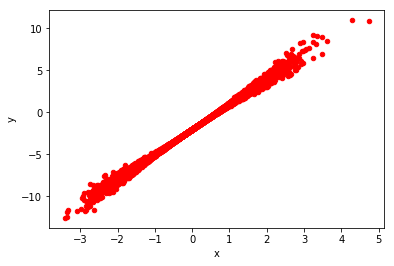

nbr of initial values: 10, size: 10000
efficienthoeffdingsD
10 loops, best of 3: 21.3 ms per loop
0.8176876523359136

Spearman
100 loops, best of 3: 9.27 ms per loop
spearman:           x         y
x  1.000000  0.999793
y  0.999793  1.000000

Kendall
100 loops, best of 3: 3.09 ms per loop
spearman:           x         y
x  1.000000  0.989366
y  0.989366  1.000000

nbr of initial values: 100, size: 100000
efficienthoeffdingsD
1 loop, best of 3: 200 ms per loop
0.8163406065098323

Spearman
10 loops, best of 3: 127 ms per loop
spearman:           x         y
x  1.000000  0.999792
y  0.999792  1.000000

Kendall
10 loops, best of 3: 31 ms per loop
spearman:           x         y
x  1.000000  0.989323
y  0.989323  1.000000

nbr of initial values: 100, size: 1000000
efficienthoeffdingsD
1 loop, best of 3: 217 ms per loop
0.8192336926700248

Spearman
1 loop, best of 3: 1.94 s per loop
spearman:           x         y
x  1.000000  0.999793
y  0.999793  1.000000

Kendall
1 loop, best of 3: 398 ms

In [24]:

#Second test: large data - EfficientHoeffdindD vs Kendall vs Spearman
print('Second test: large data - EfficientHoeffdindD vs Kendall vs Spearman')

#x=np.random.randint(10, size=10000)
x=np.random.normal(0,1, size=10000)
y=((np.random.normal(0,0.1, size=10000)*x+3)*x-2)
df=pd.DataFrame(x,columns=['x'])
df['y']=y


df.plot(kind='scatter',x='x',y='y',color='red')
plt.show()

print('nbr of initial values: 10, size: 10000')
print('efficienthoeffdingsD')
%timeit efficienthoeffdingsD( x, y )
print(efficienthoeffdingsD( x, y ))

print('')
print('Spearman')
%timeit df.corr('spearman')
print('spearman:',df.corr('spearman'))

print('')
print('Kendall')
%timeit df.corr('kendall')
print('spearman:',df.corr('kendall'))

x=np.random.normal(0,1, size=100000)
y=((np.random.normal(0,0.1, size=100000)*x+3)*x-2)
df=pd.DataFrame(x,columns=['x'])
df['y']=y
print('')
print('nbr of initial values: 100, size: 100000')
print('efficienthoeffdingsD')
%timeit efficienthoeffdingsD( x, y )
print(efficienthoeffdingsD( x, y ))

print('')
print('Spearman')
%timeit df.corr('spearman')
print('spearman:',df.corr('spearman'))

print('')
print('Kendall')
%timeit df.corr('kendall')
print('spearman:',df.corr('kendall'))

x=np.random.normal(0,1, size=1000000)
y=((np.random.normal(0,0.1, size=1000000)*x+3)*x-2)
df=pd.DataFrame(x,columns=['x'])
df['y']=y
print('')
print('nbr of initial values: 100, size: 1000000')
print('efficienthoeffdingsD')
%timeit efficienthoeffdingsD( x, y )
print(efficienthoeffdingsD( x, y ))

print('')
print('Spearman')
%timeit df.corr('spearman')
print('spearman:',df.corr('spearman'))

print('')
print('Kendall')
%timeit df.corr('kendall')
print('spearman:',df.corr('kendall'))




Third test: large data - EfficientHoeffdindD vs Kendall vs Spearman - non-monotonic relation


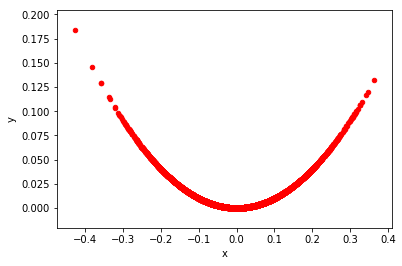

normal(0,0.1, size=10000)
efficienthoeffdingsD
10 loops, best of 3: 19.7 ms per loop
0.12427844674475626

Spearman
100 loops, best of 3: 9.19 ms per loop
spearman:           x         y
x  1.000000 -0.007585
y -0.007585  1.000000

Kendall
100 loops, best of 3: 2.96 ms per loop
spearman:           x         y
x  1.000000 -0.004799
y -0.004799  1.000000

normal(0,0.1, size=100000)
efficienthoeffdingsD
1 loop, best of 3: 192 ms per loop
0.11692637834059719

Spearman
10 loops, best of 3: 131 ms per loop
spearman:           x         y
x  1.000000 -0.003241
y -0.003241  1.000000

Kendall
10 loops, best of 3: 26.9 ms per loop
spearman:           x         y
x  1.000000 -0.003919
y -0.003919  1.000000

normal(0,0.1, size=1000000)
efficienthoeffdingsD
1 loop, best of 3: 206 ms per loop
0.12001300616937112

Spearman
1 loop, best of 3: 1.94 s per loop
spearman:          x        y
x  1.00000  0.00196
y  0.00196  1.00000

Kendall
1 loop, best of 3: 332 ms per loop
spearman:           x         y


In [7]:
#Third test: large data - EfficientHoeffdindD vs Kendall vs Spearman - non-monotonic relation
print('Third test: large data - EfficientHoeffdindD vs Kendall vs Spearman - non-monotonic relation')

x=np.random.normal(0,0.1, size=10000)
y=x*x #(np.cos(6*x))
df=pd.DataFrame(x,columns=['x'])
df['y']=y

df.plot(kind='scatter',x='x',y='y',color='red')
plt.show()

print('normal(0,0.1, size=10000)')
print('efficienthoeffdingsD')
%timeit efficienthoeffdingsD( x, y )
print(efficienthoeffdingsD( x, y ))

print('')
print('Spearman')
%timeit df.corr('spearman')
print('spearman:',df.corr('spearman'))

print('')
print('Kendall')
%timeit df.corr('kendall')
print('spearman:',df.corr('kendall'))

x=np.random.normal(0,0.1, size=100000)
y=x*x
df=pd.DataFrame(x,columns=['x'])
df['y']=y
print('')
print('normal(0,0.1, size=100000)')
print('efficienthoeffdingsD')
%timeit efficienthoeffdingsD( x, y )
print(efficienthoeffdingsD( x, y ))

print('')
print('Spearman')
%timeit df.corr('spearman')
print('spearman:',df.corr('spearman'))

print('')
print('Kendall')
%timeit df.corr('kendall')
print('spearman:',df.corr('kendall'))

x=np.random.normal(0,0.1, size=1000000)
y=x*x
df=pd.DataFrame(x,columns=['x'])
df['y']=y
print('')
print('normal(0,0.1, size=1000000)')
print('efficienthoeffdingsD')
%timeit efficienthoeffdingsD( x, y )
print(efficienthoeffdingsD( x, y ))

print('')
print('Spearman')
%timeit df.corr('spearman')
print('spearman:',df.corr('spearman'))

print('')
print('Kendall')
%timeit df.corr('kendall')
print('spearman:',df.corr('kendall'))

x=np.random.normal(0,0.1, size=1000000)
y=x*x
df=pd.DataFrame(x,columns=['x'])
df['y']=y
print('')
print('normal(0,0.1, size=1000000)')
print('efficienthoeffdingsD')
%timeit efficienthoeffdingsD( x, y )
print(efficienthoeffdingsD( x, y ))

print('')
print('Spearman')
%timeit df.corr('spearman')
print('spearman:',df.corr('spearman'))

print('')
print('Kendall')
%timeit df.corr('kendall')
print('spearman:',df.corr('kendall'))


Fourth test: large data - EfficientHoeffdindD vs Kendall vs Spearman - another non-monotonic relation


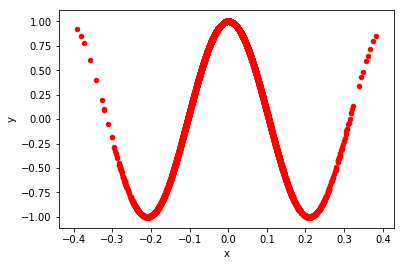

normal(0,0.1, size=10000)
efficienthoeffdingsD
10 loops, best of 3: 22.8 ms per loop
0.19124223632251608

Spearman
100 loops, best of 3: 9.35 ms per loop
spearman:           x         y
x  1.000000 -0.018652
y -0.018652  1.000000

Kendall
100 loops, best of 3: 2.98 ms per loop
spearman:           x         y
x  1.000000 -0.015962
y -0.015962  1.000000

normal(0,0.1, size=100000)
efficienthoeffdingsD
1 loop, best of 3: 205 ms per loop
0.18772380107785644

Spearman
10 loops, best of 3: 128 ms per loop
spearman:           x         y
x  1.000000 -0.006701
y -0.006701  1.000000

Kendall
10 loops, best of 3: 27.5 ms per loop
spearman:           x         y
x  1.000000 -0.006776
y -0.006776  1.000000

normal(0,0.1, size=1000000)
efficienthoeffdingsD
1 loop, best of 3: 221 ms per loop
0.1861935364668269

Spearman
1 loop, best of 3: 1.95 s per loop
spearman:           x         y
x  1.000000  0.000696
y  0.000696  1.000000

Kendall
1 loop, best of 3: 337 ms per loop
spearman:           x      

In [25]:
#Fourth test: large data - EfficientHoeffdindD vs Kendall vs Spearman - another non-monotonic relation
print('Fourth test: large data - EfficientHoeffdindD vs Kendall vs Spearman - another non-monotonic relation')

x=np.random.normal(0,0.1, size=10000)
y=(np.cos(15*x))
df=pd.DataFrame(x,columns=['x'])
df['y']=y

df.plot(kind='scatter',x='x',y='y',color='red')
plt.show()

print('normal(0,0.1, size=10000)')
print('efficienthoeffdingsD')
%timeit efficienthoeffdingsD( x, y )
print(efficienthoeffdingsD( x, y ))

print('')
print('Spearman')
%timeit df.corr('spearman')
print('spearman:',df.corr('spearman'))

print('')
print('Kendall')
%timeit df.corr('kendall')
print('spearman:',df.corr('kendall'))

x=np.random.normal(0,0.1, size=100000)
y=(np.cos(15*x))
df=pd.DataFrame(x,columns=['x'])
df['y']=y
print('')
print('normal(0,0.1, size=100000)')
print('efficienthoeffdingsD')
%timeit efficienthoeffdingsD( x, y )
print(efficienthoeffdingsD( x, y ))

print('')
print('Spearman')
%timeit df.corr('spearman')
print('spearman:',df.corr('spearman'))

print('')
print('Kendall')
%timeit df.corr('kendall')
print('spearman:',df.corr('kendall'))

x=np.random.normal(0,0.1, size=1000000)
y=(np.cos(15*x))
df=pd.DataFrame(x,columns=['x'])
df['y']=y
print('')
print('normal(0,0.1, size=1000000)')
print('efficienthoeffdingsD')
%timeit efficienthoeffdingsD( x, y )
print(efficienthoeffdingsD( x, y ))

print('')
print('Spearman')
%timeit df.corr('spearman')
print('spearman:',df.corr('spearman'))

print('')
print('Kendall')
%timeit df.corr('kendall')
print('spearman:',df.corr('kendall'))

x=np.random.normal(0,0.1, size=1000000)
y=(np.cos(6*x))
df=pd.DataFrame(x,columns=['x'])
df['y']=y
print('')
print('normal(0,0.1, size=1000000)')
print('efficienthoeffdingsD')
%timeit efficienthoeffdingsD( x, y )
print(efficienthoeffdingsD( x, y ))

print('')
print('Spearman')
%timeit df.corr('spearman')
print('spearman:',df.corr('spearman'))

print('')
print('Kendall')
%timeit df.corr('kendall')
print('spearman:',df.corr('kendall'))


#Conclusion:
despite the pure python implementation, the execution time is kept to a reasonable value for smaller dataset.
If the dataset begins to be too large, undersampling and bining are applied on the inputs. The result of these approximation has a slight impact on the HoeffdingD value. however, it stays on the same range and are in line with the values return by software as JMP.

#Ways of improvment
- A smarter bining?
